In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import xgboost as xgb
import HomeMade as hm
from sklearn.metrics import roc_curve, roc_auc_score
import importlib
hm = importlib.reload(hm)

In [2]:
N = 1e4

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.8)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_slice = int(len(mc)*0.8)
train_mc = mc[:train_test_slice]
test_mc = mc[train_test_slice:]

In [8]:

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(entrystop = N)

In [22]:
data.v0_pt

entry
0       471.442963
1       264.891479
2       369.062073
3       384.974731
4       211.513199
           ...    
9995    661.637634
9996    548.467102
9997    969.138672
9998    306.641479
9999    556.542114
Name: v0_pt, Length: 10000, dtype: float32

In [11]:
data.columns.values

array(['eventCounter', 'npv', 'ntrk_pv0', 'pv0_x', 'pv0_y', 'pv0_z',
       'a0xy', 'a0', 'a0z', 'cosTheta', 'v0_chi2', 'v0_x', 'v0_y', 'v0_z',
       'v0_rxy', 'v0_rxyErr', 'v0_px', 'v0_py', 'v0_pz', 'v0_pt', 'v0_p',
       'v0_ptErr', 'v0_ks_mass', 'v0_la_mass', 'v0_lb_mass',
       'v0_ks_massErr', 'v0_la_massErr', 'v0_lb_massErr', 'v0_px1',
       'v0_py1', 'v0_pz1', 'v0_pt1', 'v0_p1', 'v0_px2', 'v0_py2',
       'v0_pz2', 'v0_pt2', 'v0_p2', 'v0_phi1', 'v0_theta1', 'v0_qOverP1',
       'v0_phi2', 'v0_theta2', 'v0_qOverP2', 'alpha', 'calpha',
       'epsilon1', 'epsilon2', 'Alpha', 'pL1', 'pL2', 'pT', 'thetastar',
       'rapidity_ks', 'rapidity_la', 'rapidity_lb', 'pseudorapidity',
       'numberOfPixelHits1', 'numberOfSCTHits1', 'numberOfTRTHits1',
       'numberOfTRTHighThresholdHits1', 'numberOfBLayerHits1',
       'expectBLayerHit1', 'numberOfInnermostPixelLayerHits1',
       'expectInnermostPixelLayerHit1', 'numberOfPixelHits2',
       'numberOfSCTHits2', 'numberOfTRTHits2',
  

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


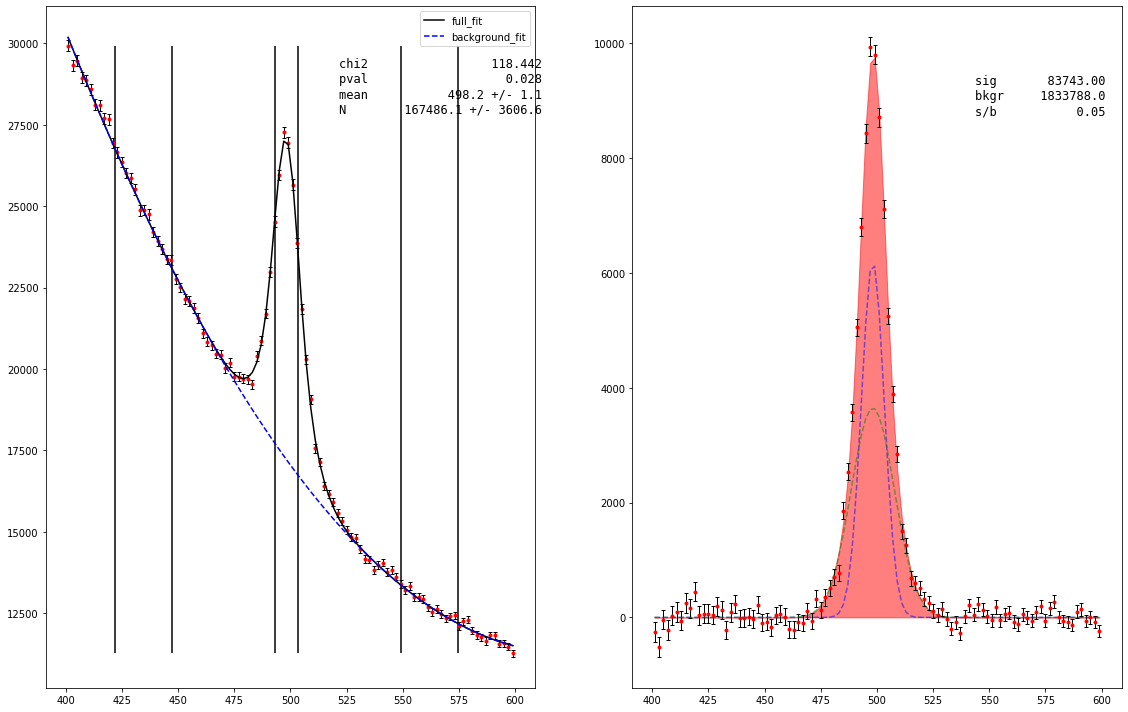

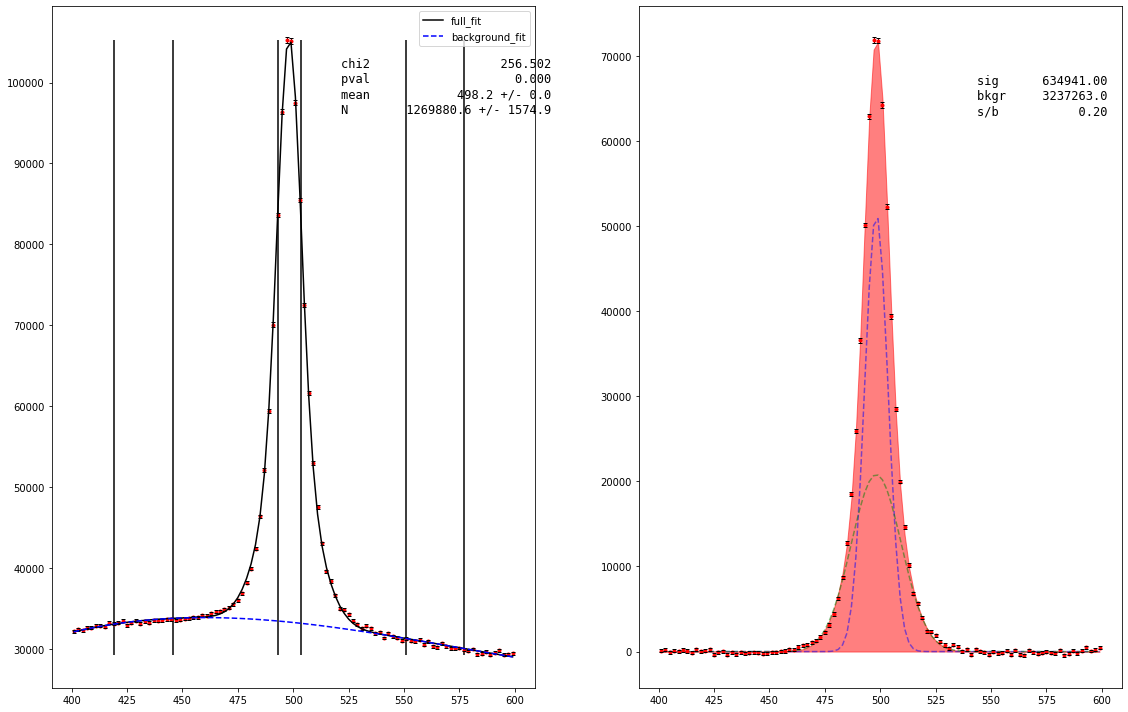

In [5]:
model1_features = "v0_chi2 v0_ks_massErr cosTheta".split(" ")
model2_features = "v0_rxyErr v0_rxy a0xy a0".split(" ")

train_data = hm.assign_pseudolabels(train_data)
train_mc_pseudo = hm.assign_pseudolabels(train_mc)

In [6]:
cla_data = xgb.XGBClassifier()
cla_mc_pseudo = xgb.XGBClassifier()
cla_mc = xgb.XGBClassifier()

In [7]:
cla_data.fit(train_data[model2_features],train_data.y)
cla_mc_pseudo.fit(train_mc_pseudo[model2_features],train_mc_pseudo.y)
cla_mc.fit(train_mc[model2_features],train_mc.trueKs)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Data trained classifier tested in data and MC:

No values, skipping..
No valid minimum found!
No values, skipping..
No valid minimum found!
No valid minimum found!


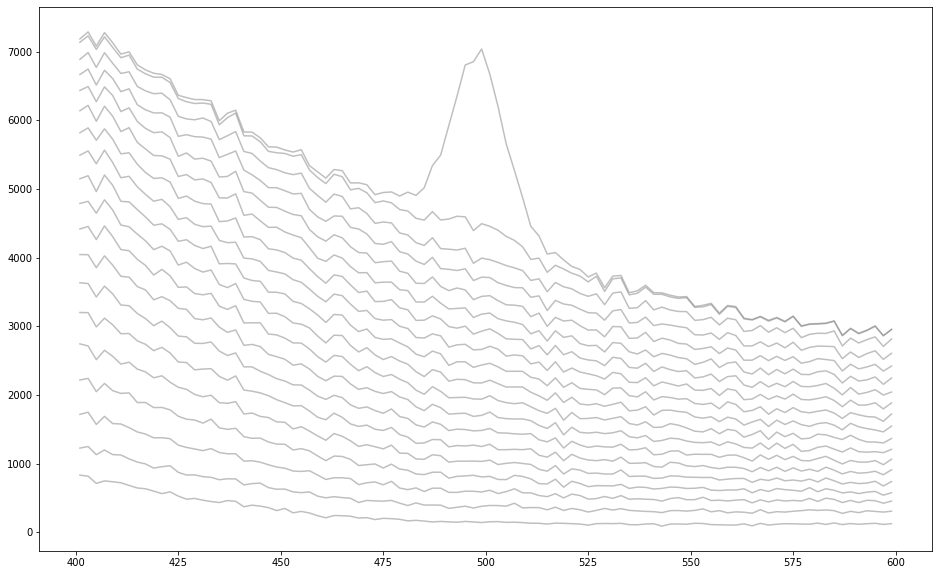

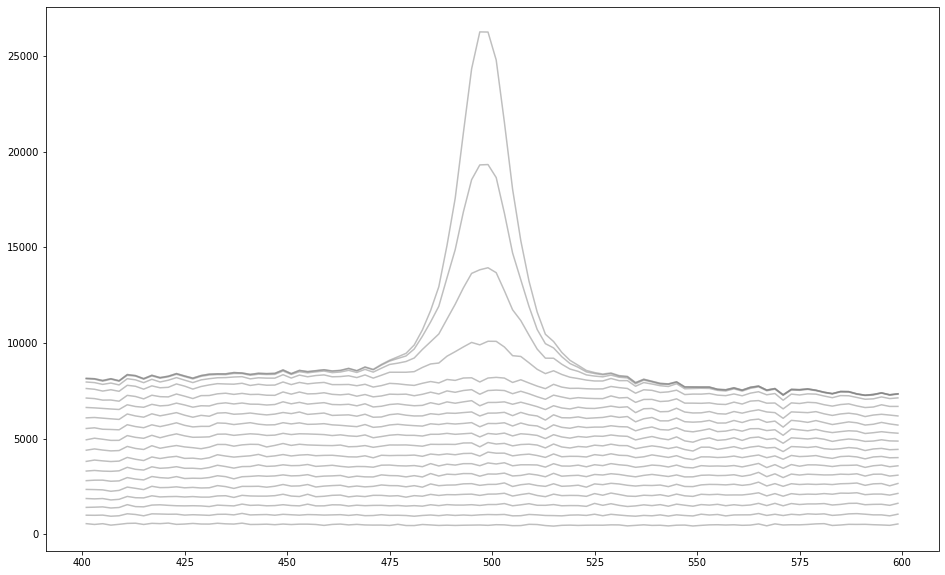

In [56]:
def roc_cla(cla):
    p_data = cla.predict_proba(test_data[model2_features])[:,1]
    p_mc = cla.predict_proba(test_mc[model2_features])[:,1]

    d_data = hm.ROC_data(test_data.v0_ks_mass,p_data,plot_fit=False,plot_ROC=False)
    d_mc = hm.ROC_data(test_mc.v0_ks_mass,p_mc,plot_fit=False,plot_ROC=False)
    return d_data, d_mc, p_mc
d_data, d_mc, p_mc = roc_cla(cla_data)

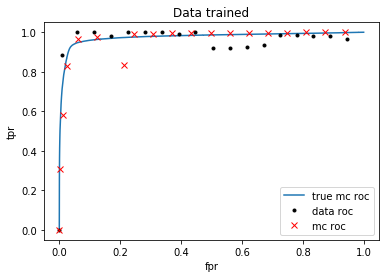

In [57]:
def compare_roc(d_data,d_mc,p_mc,title=''):
    fpr_data = 1-d_data[1]/d_data[1].max()
    tpr_data = 1-d_data[0]/d_data[0].max()
    fpr_mc = 1-d_mc[1]/d_mc[1].max()
    tpr_mc = 1-d_mc[0]/d_mc[0].max()
    fpr, tpr, thresholds = roc_curve(test_mc.trueKs,p_mc)

    fig, ax = plt.subplots()
    ax.plot(fpr,tpr,label='true mc roc')
    ax.plot(fpr_data,tpr_data,'k.',label='data roc')
    ax.plot(fpr_mc,tpr_mc,'rx', label='mc roc')
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title(title)
    ax.legend()
compare_roc(d_data,d_mc,p_mc,'Data trained')

MC pseudolabels trained classifier tested in MC and data:

No values, skipping..
No valid minimum found!
No background valid minimum found!
No background valid minimum found!
No values, skipping..
No background valid minimum found!
No background valid minimum found!


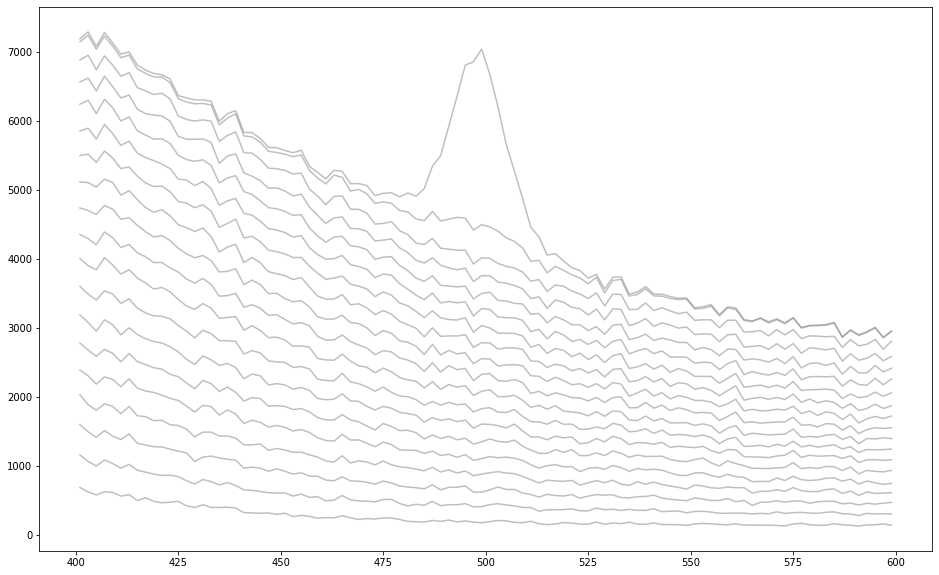

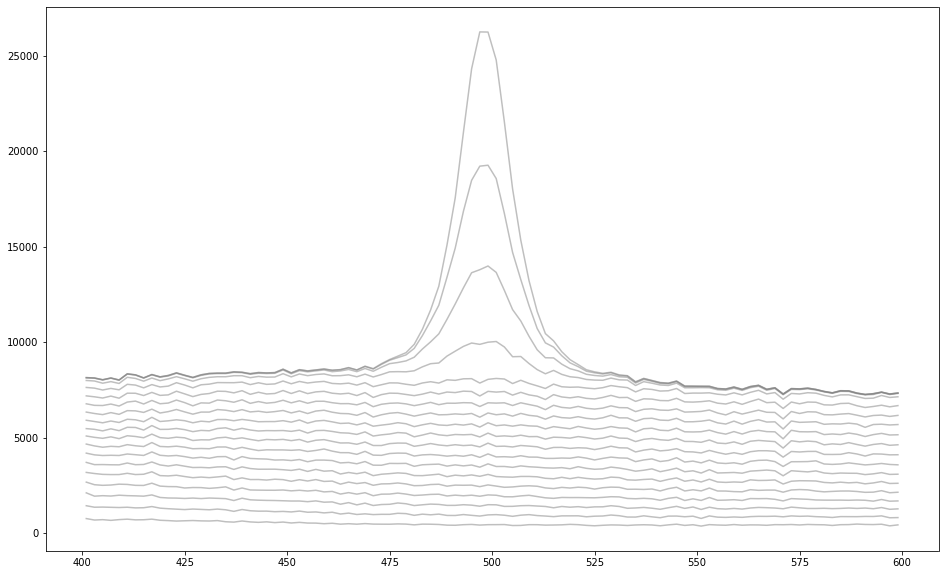

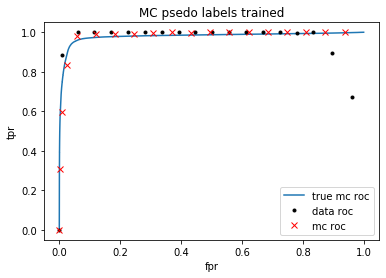

In [58]:
d_data, d_mc, p_mc = roc_cla(cla_mc_pseudo)
compare_roc(d_data,d_mc,p_mc,'MC psedo labels trained')

MC trained on true labels tested in mc and data:

No values, skipping..
No background valid minimum found!
No background valid minimum found!
No background valid minimum found!
No values, skipping..
No valid minimum found!


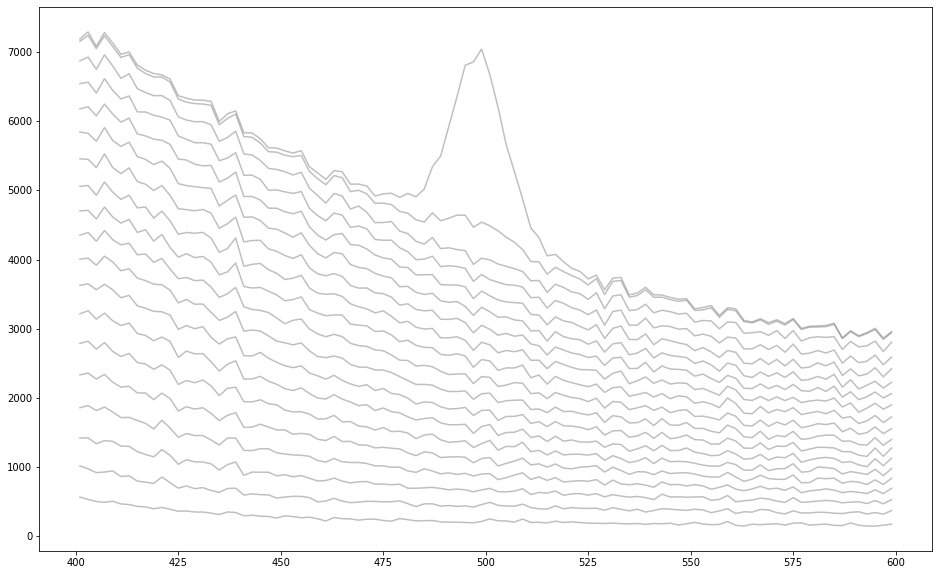

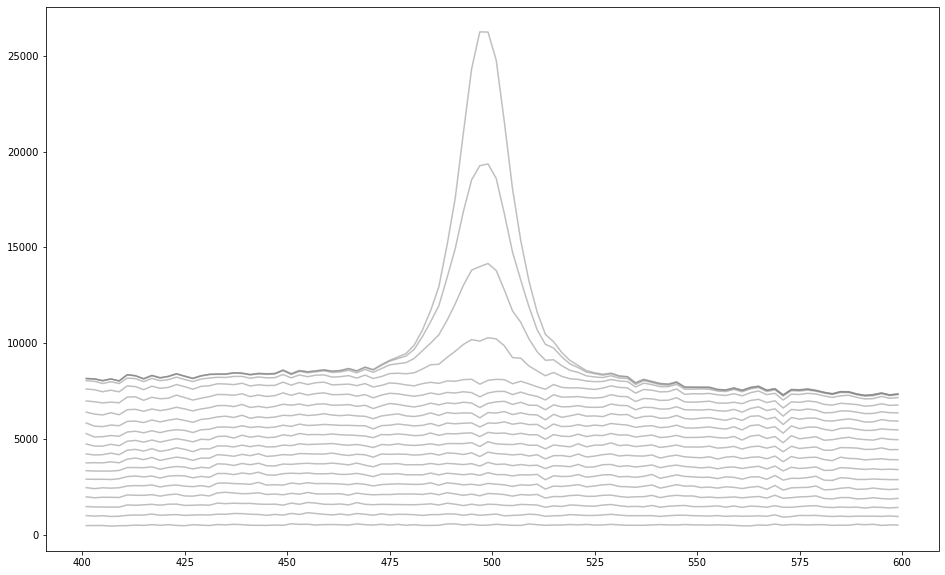

C:\Users\jv97\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


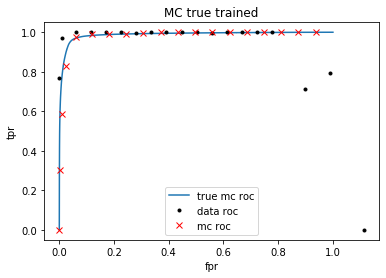

In [60]:
d_data, d_mc, p_mc = roc_cla(cla_mc)
compare_roc(d_data,d_mc,p_mc,'MC true trained')